---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 2

---

Please write your full name here
- **Name** : "Mohamed Nasser Hussein"

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import math

from sklearn.datasets import make_blobs  #To generate artificial data
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

**Use TensorFlow unless mentioned otherwise**

# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$


A regression problem for a one-dimensional case is shown below:

<img src="https://i.ibb.co/8cXVC31/fit-linreg.png" alt="fit-linreg" border="0">

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**Minibatch Stochastic Gradient Descent**


The key technique for optimizing models
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function --> *gradient descent*.

We will settle for sampling a random minibatch of examples
every time we need to compute the update --> *minibatch stochastic gradient descent*.

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [2]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [3]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


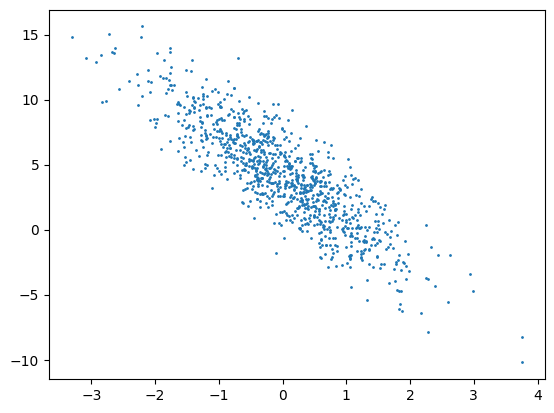

In [5]:
# The semicolon is for displaying the plot only
plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not, set the buffer size appropriately**

In [6]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    #### YOUR CODE HERE ###
    features, labels = data_arrays

    dataset=tf.data.Dataset.from_tensor_slices((features,labels))

    if is_train:
      dataset=dataset.shuffle(buffer_size=len(features))

    dataset=dataset.batch(batch_size)

    return dataset

In [7]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [8]:
next(iter(data_iter))


(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[-0.44109643,  0.29733023],
        [-0.37814665, -0.6147702 ],
        [-0.06459253,  0.17957735],
        [-1.2765387 , -0.67146075],
        [ 0.7718837 ,  1.4932712 ],
        [ 0.19340073, -0.240537  ],
        [ 1.6647202 , -1.199883  ],
        [ 1.0729338 , -0.04161261],
        [-0.05411331,  0.14211723],
        [-0.3459695 , -0.5312256 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 2.2935514],
        [ 5.5324187],
        [ 3.4383585],
        [ 3.9346645],
        [ 0.6701123],
        [ 5.3922973],
        [11.598939 ],
        [ 6.4856396],
        [ 3.6075172],
        [ 5.282805 ]], dtype=float32)>)

4. **Explain what the output shape in the prvious tensors means:**


**Answer:**
the output shapes of the tensors in the batch represent the structure of the data for that specific batch. The first dimension (10) in both tensors corresponds to the batch size, and the remaining dimensions represent the features or labels for each data sample within the batch.


5. **How many batches are in the **ENTIRE** data_iter ?**

**Answer:** 100


### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.02, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [9]:
## YOUR CODE HERE ##
W=tf.Variable(tf.random.normal(mean=0,stddev=0.02,shape=[features.shape[1],labels.shape[1]]))
b=tf.Variable(0.0)
W



<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.00074006],
       [0.00691857]], dtype=float32)>

### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [10]:
def linreg(X, w, b):
    """
    The linear regression model.
    Input:
    - X: input matrix
    - w: weights
    - bias
    """

    ## YOUR CODE HERE ##
    y_hat = tf.matmul(X*w)+b
    return y_hat

### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [11]:
def squared_loss(y_hat, y):
    """Squared loss."""
    ## YOUR CODE HERE ##
    loss = tf.reduce_mean(tf.square(y_hat-y))
    return loss

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

This function should return nothing

Note: use assign_sub


In [12]:
from tensorflow.python.ops.gen_experimental_dataset_ops import load_dataset
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    ## YOUR CODE HERE ##
    update = lr * grads / batch_size
    # Update the parameter
    params.assign(params-update)



### Training

10. **Implement the following loop**

* For each epoch :
    * For each batch in data_iter:
        * Compute the loss
        * Compute gradient
        * Update parameters
    * Calculate and print the training loss at the end of each epoch



Loss = $ l({x}, {y}) $

Gradient => $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$

Parameters update => $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.

Don't forget to use GradientTape

Set the number of epochs `num_epochs` and the learning rate `lr` to 5 and 0.02, respectively.

In [13]:
lr = 0.02
num_epochs = 5
net = linreg
loss = squared_loss

In [14]:
## YOUR CODE HERE ## The loop code
for epoch in range(num_epochs):
  total_loss=0.0
  for batch_data,batch_labels in data_iter:
    with tf.GradientTape() as tape:
      y_hat=tf.matmul(batch_data,W)+b
      l=loss(y_hat,batch_labels)
    gradients = tape.gradient(l, [W, b])
    total_loss += l
    sgd(W, gradients[0], lr, batch_size)
    sgd(b, gradients[1], lr, batch_size)
    avg_loss = total_loss / len(data_iter)

  print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {avg_loss:.4f}')



Epoch [1/5] - Training Loss: 22.1163
Epoch [2/5] - Training Loss: 10.3519
Epoch [3/5] - Training Loss: 4.8587
Epoch [4/5] - Training Loss: 2.2855
Epoch [5/5] - Training Loss: 1.0774


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned through our training loop**] (final w, b). They should turn out to be very close to each other.

calculate the difference!!


In [15]:
print(W[:,0],true_w)

tf.Tensor([ 1.602156  -2.8955665], shape=(2,), dtype=float32) tf.Tensor([ 2.  -3.4], shape=(2,), dtype=float32)


In [16]:
## YOUR CODE HERE ##
w_error = tf.abs(W[:,0]- true_w)
b_error = tf.abs(b - true_b)
print(f'Error in estimating w: {w_error.numpy()}')
print(f'Error in estimating b: {b_error.numpy()}')

Error in estimating w: [0.39784396 0.50443363]
Error in estimating b: 0.5998563766479492


## Diabetes Dataset

In this section, we will use SKLEARN's Diabetes dataset

### Loading the Dataset

1. **Load the Diabetes dataset from sklearn**

In [2]:
from sklearn.datasets import load_diabetes
## YOUR CODE HERE ##
# Load the diabetes dataset
diabetes = load_diabetes()


2. **Look at the keys of diabetes_dataset dictionary**

In [3]:
## YOUR CODE HERE ##

### Look at keys to determine the data
keys = diabetes.keys()
print(keys)


dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


3. **Use the key DESCR to understand the dataset**

In [4]:
## YOUR CODE HERE ##
description = diabetes.DESCR
print(description)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

4. **Save the data and target variables in numpy arrays and print their shapes**

In [5]:
### START CODE HERE ### (≈ 2 lines of code)
data = diabetes.data
targets = diabetes.target
### END CODE HERE ###

print ('The shape of data is: ' + str(data.shape))
print ('The shape of targets is: ' + str(targets.shape))
print ('I have f = %d features!' % (data.shape[1]))
print ('I have m = %d examples!' % (data.shape[0]))

The shape of data is: (442, 10)
The shape of targets is: (442,)
I have f = 10 features!
I have m = 442 examples!


5. **What are the ranges of each column in features and the target column?**
    - *Hint* you might find it helpful to convert to pandas dataframe and use ".describe"

In [6]:
import pandas as pd
### START CODE HERE ###
data=pd.DataFrame(data)
data.describe().loc[['min','max']]
### END CODE HERE ###

,0,1,2,3,4,5,6,7,8,9
min,-0.107226,-0.044642,-0.090275,-0.112399,-0.126781,-0.115613,-0.102307,-0.076395,-0.126097,-0.137767
max,0.110727,0.050680,0.170555,0.132044,0.153914,0.198788,0.181179,0.185234,0.133597,0.135612


### Preparing the data

6. **Split the data into train and test set using sklearn train_test_split.** Have the test set as 10% of data

In [9]:
import sklearn
np.random.seed(0)
### START CODE HERE ###
# Split the data into train and test sets
X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(data,targets,test_size=0.1)

### END CODE HERE ###

print("Shape of training data is", X_train.shape)
print("Shape of training targets is", y_train.shape)
print("Shape of test data is", X_test.shape)
print("Shape of test targets is", y_test.shape)

Shape of training data is (397, 10)
Shape of training targets is (397,)
Shape of test data is (45, 10)
Shape of test targets is (45,)


- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.
- **Question:** Should we normalize features? WHY?
    - ANSWER: Yes, Normalizing features can lead to faster convergence during the training of machine learning models.
    - Features often have different scales and units. Normalizing them (e.g., scaling to a range of 0 to 1) can help machine learning algorithms

7. **normalize the targets**

In [10]:
### START CODE HERE ### (≈ 6 lines of code)

from sklearn.preprocessing import StandardScaler
target_scaler = StandardScaler()
y_train_normalized = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_normalized = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

### END CODE HERE ###

### Building your model

7. **Use tf.keras.Sequential to build a model with:**
    - 6 hidden layers each having 128 neurons and relu activation.
    - 1 output layer
    - use input_shape argument to specify input size in 1st layer
- **Question:** How many neurons should be in output layer? What should be the activation?
    - ANSWER: one neuron
    -  Activation function: no activation

In [26]:
def build_model(input_shape):
    ### START CODE HERE ### ()
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu',input_shape=[input_shape],name='input_layer'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_layer1'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_layer2'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_layer3'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_layer4'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_layer5'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_layer6'),
        tf.keras.layers.Dense(1, name='output_layer')
    ])

    return model

In [27]:
# Print the model summary
input_shape=(X_train.shape[1])
model = build_model(input_shape)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 128)               1408      
                                                                 
 hidden_layer1 (Dense)       (None, 128)               16512     
                                                                 
 hidden_layer2 (Dense)       (None, 128)               16512     
                                                                 
 hidden_layer3 (Dense)       (None, 128)               16512     
                                                                 
 hidden_layer4 (Dense)       (None, 128)               16512     
                                                                 
 hidden_layer5 (Dense)       (None, 128)               16512     
                                                                 
 hidden_layer6 (Dense)       (None, 128)              

8. **Compile the model using optimizer=Adam, loss=mean squared loss, metrics=mean absoluute error:**

In [28]:
### START CODE HERE ### ()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

9. **FIT the model using for 110 epochs, 64 batch size and a validation split of 0.1**

In [29]:
### START CODE HERE ### ()
history = model.fit(
    X_train,  # Training data
    y_train_normalized,  # Normalized training targets
    epochs=110,  # Number of epochs
    batch_size=64,  # Batch size
    validation_split=0.1  # Validation split
)

Epoch 1/110
6/6 [==============================] - 2s 45ms/step - loss: 0.9673 - mae: 0.8372 - val_loss: 1.1417 - val_mae: 0.9159
Epoch 2/110
6/6 [==============================] - 0s 14ms/step - loss: 0.8747 - mae: 0.7934 - val_loss: 0.9150 - val_mae: 0.8246
Epoch 3/110
6/6 [==============================] - 0s 10ms/step - loss: 0.6660 - mae: 0.6790 - val_loss: 0.6307 - val_mae: 0.6646
Epoch 4/110
6/6 [==============================] - 0s 9ms/step - loss: 0.6002 - mae: 0.6316 - val_loss: 0.5756 - val_mae: 0.5723
Epoch 5/110
6/6 [==============================] - 0s 10ms/step - loss: 0.5116 - mae: 0.5761 - val_loss: 0.5892 - val_mae: 0.6671
Epoch 6/110
6/6 [==============================] - 0s 9ms/step - loss: 0.4818 - mae: 0.5826 - val_loss: 0.5495 - val_mae: 0.5836
Epoch 7/110
6/6 [==============================] - 0s 9ms/step - loss: 0.4642 - mae: 0.5490 - val_loss: 0.4925 - val_mae: 0.5870
Epoch 8/110
6/6 [==============================] - 0s 9ms/step - loss: 0.4349 - mae: 0.5280 -

In [30]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test_normalized)

# Print the test loss and mean absolute error (MAE)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')


2/2 [==============================] - 0s 9ms/step - loss: 0.7966 - mae: 0.7151
Test Loss: 0.7966
Test MAE: 0.7151


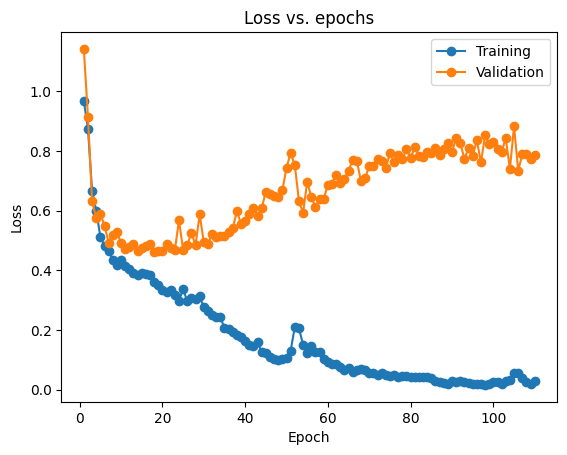

In [31]:
# Plot the training and validation loss

plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss', marker='o')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

9. **Diagnose the learning curve:**
    - Why is the validation loss much higher than training loss?
    - What's this phenomenon called?
    - Mention 3 methods to reduce this.

- **answer**:
    1. Training for a large number of epochs (in this case, 110)
      A validation split of 10% of the training data is relatively small
   
    2. Overfitting

    3. - Early Stopping: Monitor the validation loss and stop training when it   starts to increase
      - Data Augmentation
      - Simplify the Model: Reduce the complexity of the model by reducing the number of layers or neurons. Simpler models are less prone to overfitting.
      - Decrease batch size.
      - Decrease number of epochs.
      - Regularization

10. **Use one of the methods you mentioned and retrain the model then plot the learning curves**

Epoch 1/110
6/6 [==============================] - 3s 99ms/step - loss: 8.3376 - mae: 0.8402 - val_loss: 8.0209 - val_mae: 0.9375
Epoch 2/110
6/6 [==============================] - 0s 22ms/step - loss: 7.4846 - mae: 0.8335 - val_loss: 7.2077 - val_mae: 0.9266
Epoch 3/110
6/6 [==============================] - 0s 21ms/step - loss: 6.6988 - mae: 0.8197 - val_loss: 6.4528 - val_mae: 0.9082
Epoch 4/110
6/6 [==============================] - 0s 19ms/step - loss: 5.9692 - mae: 0.7966 - val_loss: 5.7317 - val_mae: 0.8713
Epoch 5/110
6/6 [==============================] - 0s 20ms/step - loss: 5.2809 - mae: 0.7489 - val_loss: 5.0383 - val_mae: 0.8204
Epoch 6/110
6/6 [==============================] - 0s 19ms/step - loss: 4.6339 - mae: 0.6765 - val_loss: 4.4040 - val_mae: 0.6955
Epoch 7/110
6/6 [==============================] - 0s 26ms/step - loss: 4.0954 - mae: 0.5844 - val_loss: 3.9160 - val_mae: 0.6323
Epoch 8/110
6/6 [==============================] - 0s 44ms/step - loss: 3.6652 - mae: 0.58

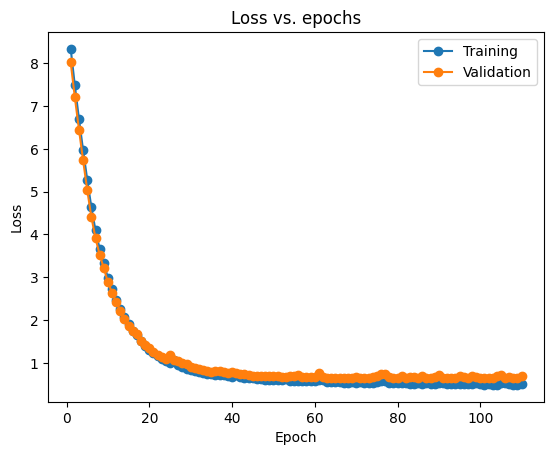

In [39]:
#### YOUR CODE HERE
### START CODE HERE ### ()
from tensorflow.keras import regularizers
input_shape=(X_train.shape[1])
model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu',input_shape=[input_shape],name='input_layer'),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), name='hidden_layer1'),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), name='hidden_layer2'),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), name='hidden_layer3'),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), name='hidden_layer4'),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), name='hidden_layer5'),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), name='hidden_layer6'),
        tf.keras.layers.Dense(1, name='output_layer')
    ])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model.fit(
    X_train,  # Training data
    y_train_normalized,  # Normalized training targets
    epochs=110,  # Number of epochs
    batch_size=64,  # Batch size
    validation_split=0.1,  # Validation split
)

# Plot the training and validation loss

plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss', marker='o')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Part 3 Batches and Epochs

In this part of the assignment we will create a synthetic data to play with.
The data will have 2 features and 3 target classes --> multiclass classification problem

In [31]:
# prepare train and test dataset
def prepare_data():
    #  generate classification dataset with 3 centers (labels/classes)
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

    # plot data
    for class_value in range(3):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()

    # one hot encode output variable to convert from integers to binary class
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, y_train, X_test, y_test


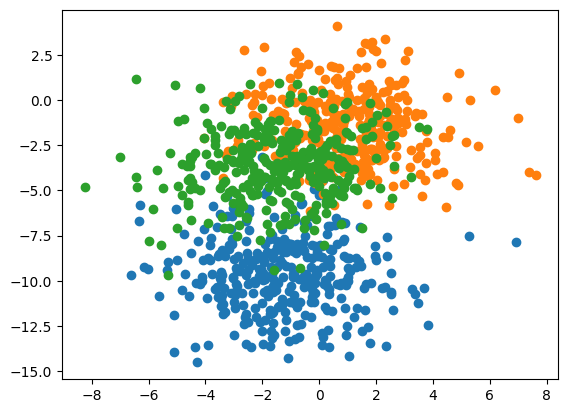

(500, 2)

In [32]:
# prepare dataset
X_train, y_train, X_test, y_test = prepare_data()
X_train.shape

- **Create a model with:**
    -  1 hidden dense layer (50 neurons), activation relu, , kernel_initializer he_uniform
    - 1 output layer
    - compile the model with SGD (learning rate 0.01 and momentum 0.9) optimizer and categorical crossentropy and accuracy inside build function

In [33]:
lr=0.01
def build_model():

    ##### YOUR CODE HERE
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model


- Create a function to fit and build the model with different batch sizes

Use epochs = 125

In [34]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch):
    ##### YOUR CODE HERE
    history = model.fit(X_train, y_train, epochs=125, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)
    return history

### Hyperparameter Tuning

#### Batch size

##### Size =  1

10. **train for 1 batch size**

In [35]:
### START CODE HERE ###
model=build_model()
batch_size=1
history=fit_model(X_train, y_train, X_test, y_test,batch_size)


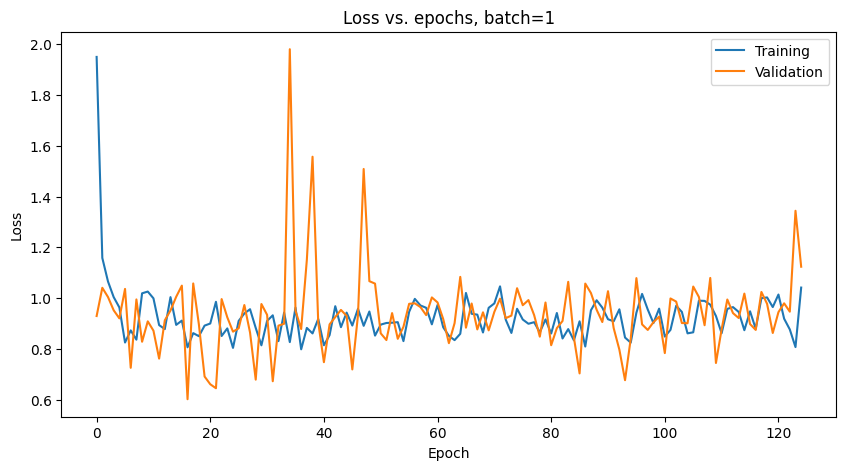

In [36]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

- **Diagnose this curve w.r.t learning rate**:
    - ANSWER: Learning Rate Too High
      causing the optimization process to overshoot the optimal parameter values. This results in the loss function oscillating without converging
- Change learning rate to make this curve better

In [42]:
### Your answer
lr=0.001

In [43]:
def build_model():
     ##### YOUR CODE HERE
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model
model=build_model()

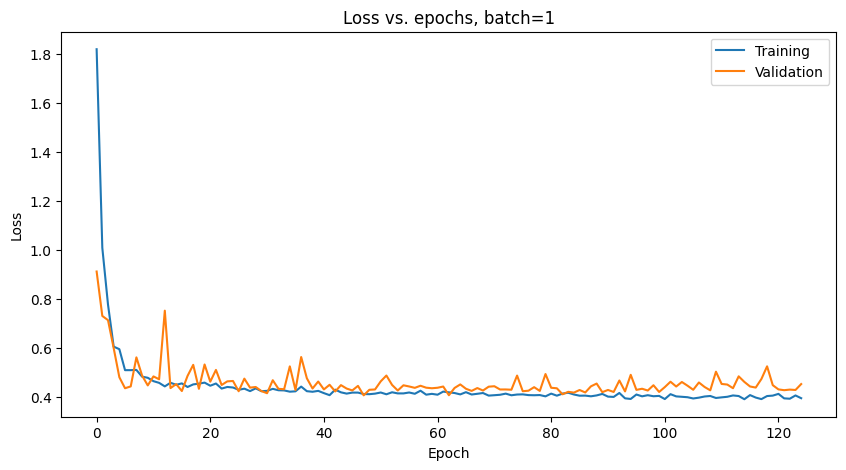

In [44]:
batch_size = 1
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  16

10. **Retrain for 16 batch size**

In [45]:
### START CODE HERE ###
model=build_model()
batch_size = 16
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

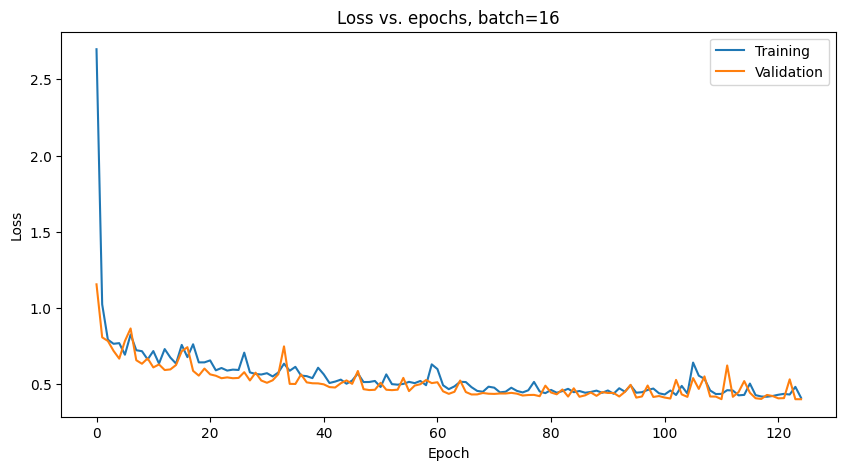

In [46]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  128

10. **Retrain for 128 batch size**

In [47]:
### START CODE HERE ###
model=build_model()
batch_size = 128
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

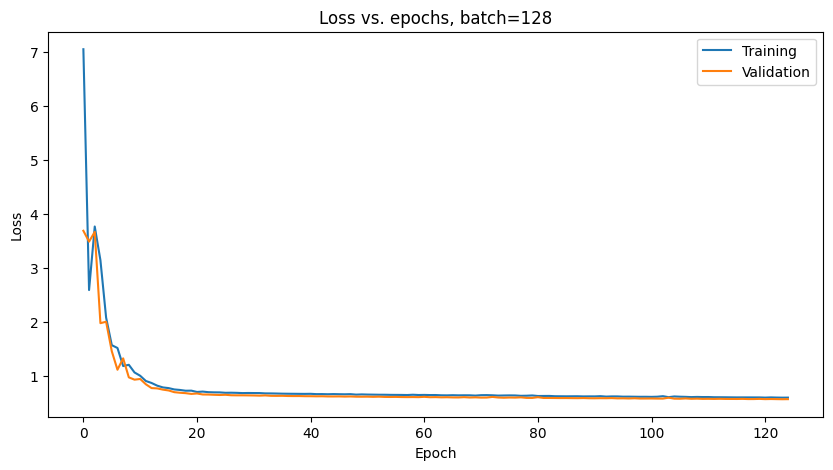

In [48]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  Data

10. **Retrain for length of data batch size**

In [49]:
### START CODE HERE ###
model=build_model()
batch_size = len(X_train)
history = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

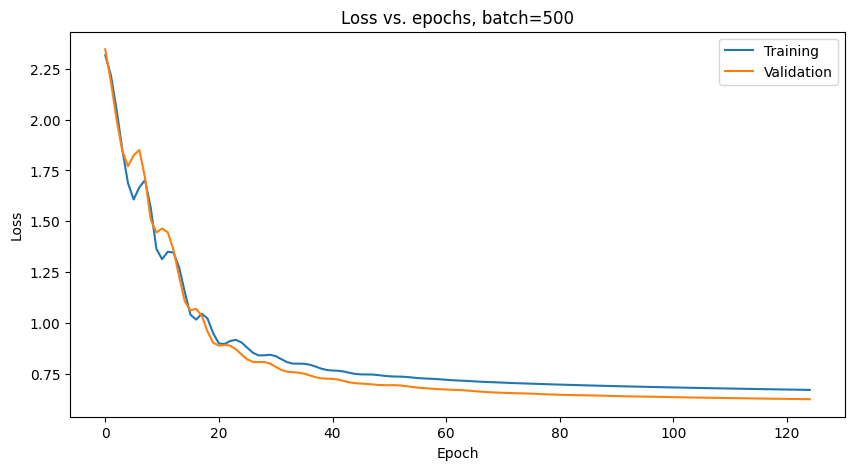

In [50]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing batch size have on learning in terms of convergence and fluctuations?**

**Answer:**
Using a larger batch size often leads to faster convergence.
Each batch provides a more accurate estimate of the gradient, resulting in smoother and more predictable updates to the model's parameters.

larger batch sizes tend to produce smoother and more stable training curves. The training loss and validation loss often exhibit fewer fluctuations


#### Learning Rate

batch size 64

- **Use same code for build_model above, add an argument learning rate to change learning rate of optmizer**

In [51]:
def build_model(lr):
     ##### YOUR CODE HERE
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model

##### LR =  0.00001

10. **Retrain for 0.00001 LR**

In [52]:
### START CODE HERE ### ()
lr=0.00001
model=build_model(lr)
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size)

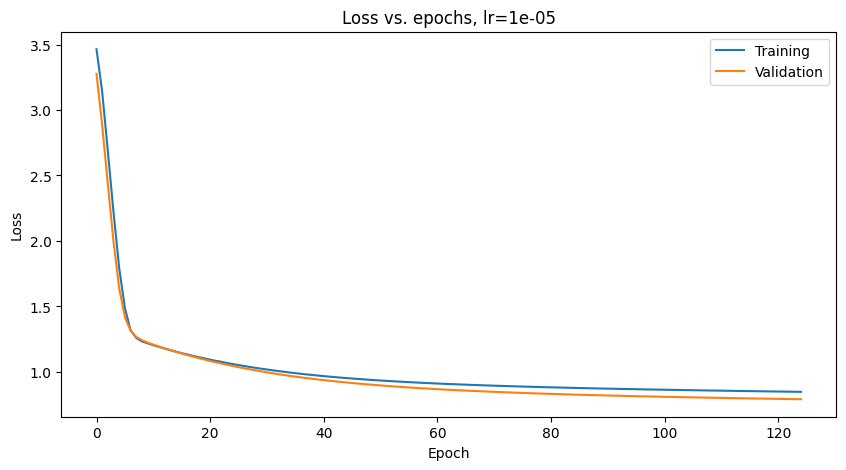

In [53]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.001

10. **Retrain for 0.001 LR**

In [54]:
### START CODE HERE ### ()
lr=0.001
model=build_model(lr)
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size)

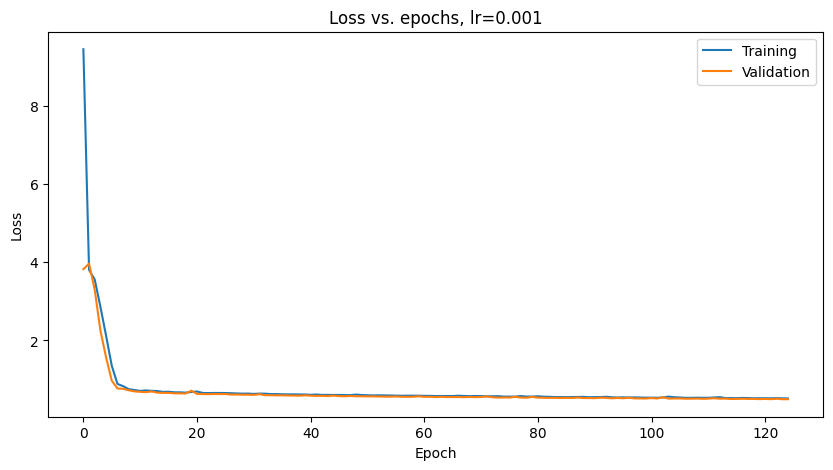

In [55]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.1

10. **Retrain for 0.1 LR**

In [56]:
### START CODE HERE ### ()
### START CODE HERE ### ()
lr=0.1
model=build_model(lr)
batch_size = 64
history = fit_model(X_train, y_train, X_test, y_test, batch_size)

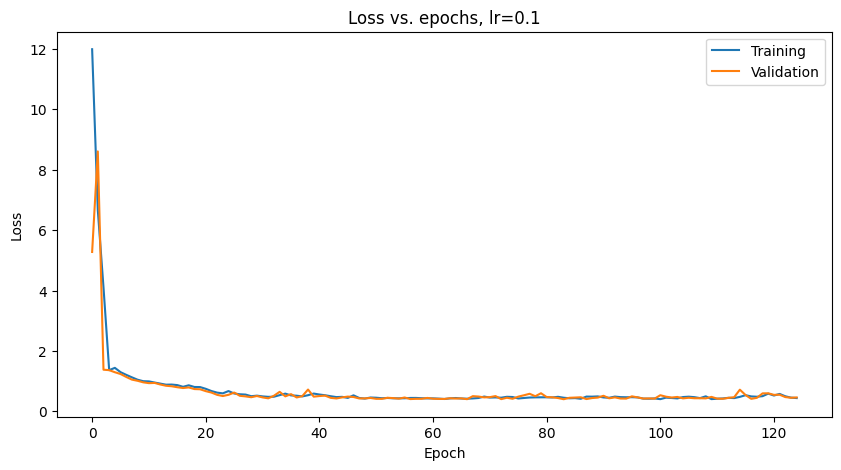

In [57]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing learning rate have on learning?**

A lower learning rate results in smaller parameter updates. While this can lead to more stable and controlled training,it may require more training epochs to reach convergence,smooth learning rate.

Higher Learning Rate: A higher learning rate results in larger parameter updates,This leads to faster convergence as the model quickly adjusts its parameters but the learning curve is not smooth.


**Answer:**

**Questions**

1. Mention 1 advantage of a computational graph?

**Answer:**
It allows for automatic differentiation, which simplifies the process of computing gradients. This is particularly useful when implementing gradient-based optimization algorithms such as stochastic gradient descent. Computational graphs provide a systematic and efficient way to compute gradients, making it easier to train complex models with many parameters.

2. Mention two ways to input data for training using TensorFlow if the data resides on disk

**Answer:**
1. tf.data API: TensorFlow's tf.data API

2. tf.keras.preprocessing.image.ImageDataGenerator: If you are working with image data